# Expectation–maximization for Clustering

This code follows chapters 9 and 10 of the Bishop Book.

Important formulas:

$$
    \log q_j^\star(z_j) = \mathbb{E}_{i \neq j} \log p(X, Z) + \mathrm{const}
$$

$$
    P(X, Z) = P(X|\theta, Z) P(Z | \pi)
$$

In [ ]:
%matplotlib inline

In [ ]:
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import seaborn as sns

In [ ]:
class EMMixtureModel(object):
    def __init__(self, n_components, n_iter=100):
        self.n_components = n_components 
        self.n_iter = n_iter

        self._mixture_weights = None
        self._params = None
        
    def fit(self, *x):
        params = self._initial_params()
        pi = np.ones(self.n_components) / self.n_components
        
        for _ in range(self.n_iter):
            gamma = self._responsibility(x, pi, params)
            params = self._sufficient_statistics(gamma, x)

            pi = gamma.sum(axis=1)
            pi /= pi.sum()
        
        self._mixture_weights = pi
        self._params = params
        return self
    
    def predict_proba(self, *x):
        return sum(
            self._mixture_weights[i] * self._component_density(x, self._mixture_params(i, self._params))
            for i in range(self.n_components)
        )
    
    def predict_responsibility(self, *x):
        return self._responsibility(x, self._mixture_weights, self._params)
    
    @staticmethod
    def _mixture_params(i, params):
        return [p[i] for p in params]
    
    def _responsibility(self, x, pi, parameters):
        result = [
            pi[i] * self._component_density(x, self._mixture_params(i, parameters))
            for i in range(self.n_components)
        ]
        
        result = np.stack(result)
        result /= result.sum(axis=0, keepdims=True)

        return result
    
    def _initial_params(self):
        raise NotImplementedError()
    
    def _component_density(self, ):
        raise NotImplementedError()
    
    def _sufficient_statistics(self, gamma, x):
        raise NotImplementedError()
        
        
class GaussianMixtureModel(EMMixtureModel):
    @staticmethod
    def _component_density(x, params):
        x, = x
        mu, sigma = params
        d = (x - mu) / sigma
        return np.exp(-d ** 2.0) / (np.sqrt(2.0 * np.pi) * sigma)
    
    @staticmethod
    def _sufficient_statistics(gamma, x):
        x, = x
        Nk = gamma.sum(axis=1)

        mu = (gamma * x).sum(axis=1) / Nk
        sigma = (gamma * (x - mu[..., None]) ** 2.0).sum(axis=1) / Nk
        sigma **= 0.5

        return mu, sigma
    
    @staticmethod
    def _initial_params():
        mu = np.random.uniform(-20, +20, 3)
        sigma = np.ones(3)

        return mu, sigma
    
    
class PoissonMixtureModel(EMMixtureModel):
    @staticmethod
    def _component_density(x, params):
        x, = x
        mu, = params
        
        # use numerically stable evaluation method, taken from wikipedia
        p = np.exp(x * np.log(mu) - mu - scipy.special.gammaln(x + 1))
        return p
        
    @staticmethod
    def _sufficient_statistics(gamma, x):
        x, = x
        Nk = gamma.sum(axis=1)
        mu = (gamma * x).sum(axis=1) / Nk
        return mu,
    
    def _initial_params(self):
        mu = np.random.gamma(1.0, 10.0, self.n_components)
        return mu,
    
    
class ExponentialMixtureModel(EMMixtureModel):
    @staticmethod
    def _component_density(x, params):
        x, = x
        tau, = params
        return np.exp(-x / tau) / tau
        
    @staticmethod
    def _sufficient_statistics(gamma, x):
        x, = x
        tau = (gamma * x).sum(axis=1) / gamma.sum(axis=1)
        return tau,
    
    def _initial_params(self):
        tau = np.random.gamma(1.0, 10.0, self.n_components)
        return tau,
    

class ExponentialSurvivalMixtureModel(EMMixtureModel):
    @staticmethod
    def _component_density(x, params):
        t, d = x
        tau, = params
        norm = 1.0 + d * (tau - 1)
        return np.exp(-t / tau) / norm
        
    @staticmethod
    def _sufficient_statistics(gamma, x):
        t, d = x
        
        T = (gamma * t).sum(axis=1)
        D = (gamma * d).sum(axis=1)
        return T / D,
    
    def _initial_params(self):
        tau = np.random.gamma(1.0, 10.0, self.n_components)
        return tau,


In [ ]:
color_cycle = mpl.rcParams['axes.prop_cycle'].by_key()['color']

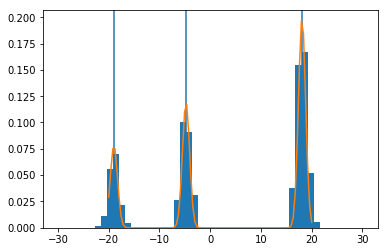

In [ ]:
n_clusters = 3

np.random.seed(100)
cluster = np.random.choice(range(n_clusters), p=[0.2, 0.3, 0.5], size=1000)
centers = np.random.uniform(-20, 20, size=n_clusters)
x = np.random.normal(centers[cluster], 1.0)

model = GaussianMixtureModel(n_components=3)
model.fit(x)

xp = np.linspace(-20, 20, 100)
pp = model.predict_proba(xp)

plt.hist(x, range=(-30, 30), bins=50, normed=True)
for c in centers:
    plt.axvline(x=c)

plt.plot(xp, pp)

pass

# Poisson clustering

$$
    p(k; \mu) = \frac{\mu^k}{k!} e^{-\mu}
$$

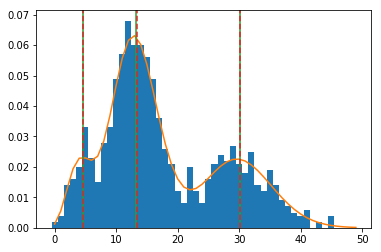

In [ ]:
np.random.seed(42)
mu = np.random.gamma(1.0, 10.0, 3)
z = np.random.choice([0, 1, 2], p=[0.1, 0.3, 0.6], size=1000)
x = np.random.poisson(mu[z])

model = PoissonMixtureModel(n_components=3)
model.fit(x)

xp = np.arange(50)
pp = model.predict_proba(xp)

plt.hist(x, bins=np.arange(50) - 0.5, normed=True)
plt.plot(xp, pp, color=color_cycle[1])

for c in mu:
    plt.axvline(c, color=color_cycle[2])
    
for c in model._params[0]:
    plt.axvline(c, color=color_cycle[3], ls='--')
    
pass

# Exponential Distribution

Probability to observe an event at time $t$:

$$
    f(t;\tau) = \frac{e^{-t / \tau}}{\tau}
$$

$$
    \tau^\star = \frac{1}{N} \sum_i t_i
$$

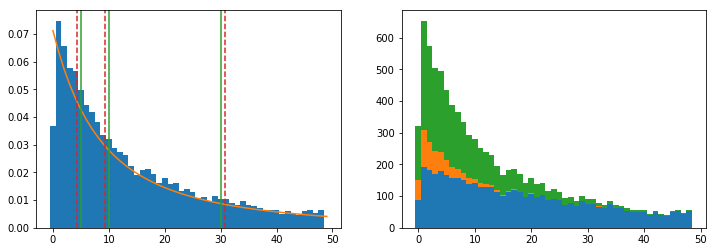

In [ ]:
np.random.seed(70)
mu = np.asarray([5.0, 10.0, 30.0])
z = np.random.choice([0, 1, 2], p=[0.1, 0.3, 0.6], size=10000)
x = np.random.exponential(mu[z])

model = ExponentialMixtureModel(n_components=3)
model.fit(x)

xp = np.arange(50)
pp = model.predict_proba(xp)
g = model.predict_responsibility(x)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.hist(x, bins=np.arange(50) - 0.5, normed=True)
plt.plot(xp, pp, color=color_cycle[1])

for c in mu:
    plt.axvline(c, color=color_cycle[2])
    
for c in model._params[0]:
    plt.axvline(c, color=color_cycle[3], ls='--')
    
plt.subplot(1, 2, 2)
plt.hist([x] * model.n_components, weights=g, stacked=True, bins=np.arange(50) - 0.5)

pass

# Exponential Survival Models

Probability to observe an event at time $t$:

$$
    f(t;\tau) = \frac{e^{-t / \tau}}{\tau}
$$

For not yet observed events, we only know that the true time has to be larger than the observation time $t_f$. The likelihood for such an event is given by

$$
    S(t_f) = \int_{t_f}^\infty \mathrm{d}u\; f(u) = e^{-t_f / \tau}
$$

This yields the log-likelihood:

$$
    \mathcal{L} = 
        -\sum_{i \in \text{obs.}} \frac{t_i}{\tau} 
        -\sum_{i \in \text{not obs.}} \frac{t_f}{\tau}
        -\sum_{i \in \text{obs.}} \log \tau
$$

The optimimum can be found as:

$$
\begin{align}
    \tau^\star &= \frac{T}{D} 
\\
    T &= \sum_i \begin{cases}
        t_i & \text{if event is observed} \\
        t_f & \text{if event is not observed}
    \end{cases}
\\
    D &= \sum_i \begin{cases}
        1 & \text{if event is observed} \\
        0 & \text{if event is not observed}
    \end{cases}
\end{align}
$$

For mixtures, the sums for both $T$ and and $D$ have to be weighted by $\gamma_i$.

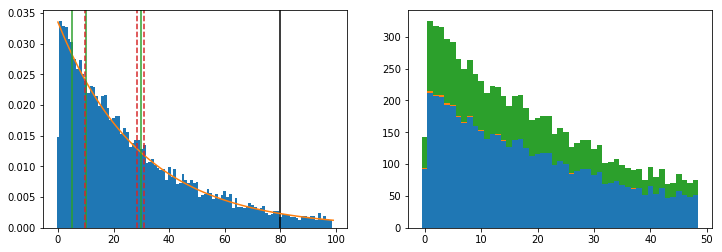

In [ ]:
np.random.seed(70)
mu = np.asarray([5.0, 10.0, 30.0])
z = np.random.choice([0, 1, 2], p=[0.1, 0.3, 0.6], size=10000)
z = 2 + 0 * z
x = np.random.exponential(mu[z])

tc = 80
d = x <= tc
y = np.minimum(tc, x)

model = ExponentialSurvivalMixtureModel(n_components=3)
model.fit(y, d)

xp = np.arange(100)
pp = model.predict_proba(xp, np.ones_like(xp))
g = model.predict_responsibility(y, d)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.hist(x, bins=np.arange(100) - 0.5, normed=True)
plt.axvline(x=tc, color='k', ls="-")
plt.plot(xp, pp, color=color_cycle[1])

for c in mu:
    plt.axvline(c, color=color_cycle[2])
    
for c in model._params[0]:
    plt.axvline(c, color=color_cycle[3], ls='--')

plt.subplot(1, 2, 2)
plt.hist([x] * model.n_components, weights=g, stacked=True, bins=np.arange(50) - 0.5)
    
pass